<a href="https://colab.research.google.com/github/100jy/dacon_ts_forecasting/blob/main/UberApproach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 참고
- https://eng.uber.com/forecasting-introduction/

- https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

# 모듈 임포트

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install torchcontrib

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
from torch.optim.swa_utils import AveragedModel, SWALR
from torch.utils.data import Dataset
import torch.optim.adam
from torchcontrib.optim import SWA
import datetime
import matplotlib.pyplot as plt 
from tqdm import tqdm
import random



# 추가변수

In [4]:
train = pd.read_csv("./drive/MyDrive/데이콘/train.csv", encoding = 'euc-kr')
date_time = pd.to_datetime(train.DateTime)

#일자
train['Date'] = date_time.dt.date
train = train.groupby(train['Date']).sum().reset_index()  

In [5]:
# 로그인 횟수
login =  pd.read_csv("./drive/MyDrive/데이콘/info_login.csv", encoding = 'euc-kr', index_col=0)
login['c_time'] = pd.to_datetime(login['c_time']).dt.date
login = login.groupby('c_time').count()['login_id'].reset_index()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# 로그인수 폭발적으로 증가하는 경우
login['event'] = login['login_id'] > (login['login_id'].rolling(30).mean())*2

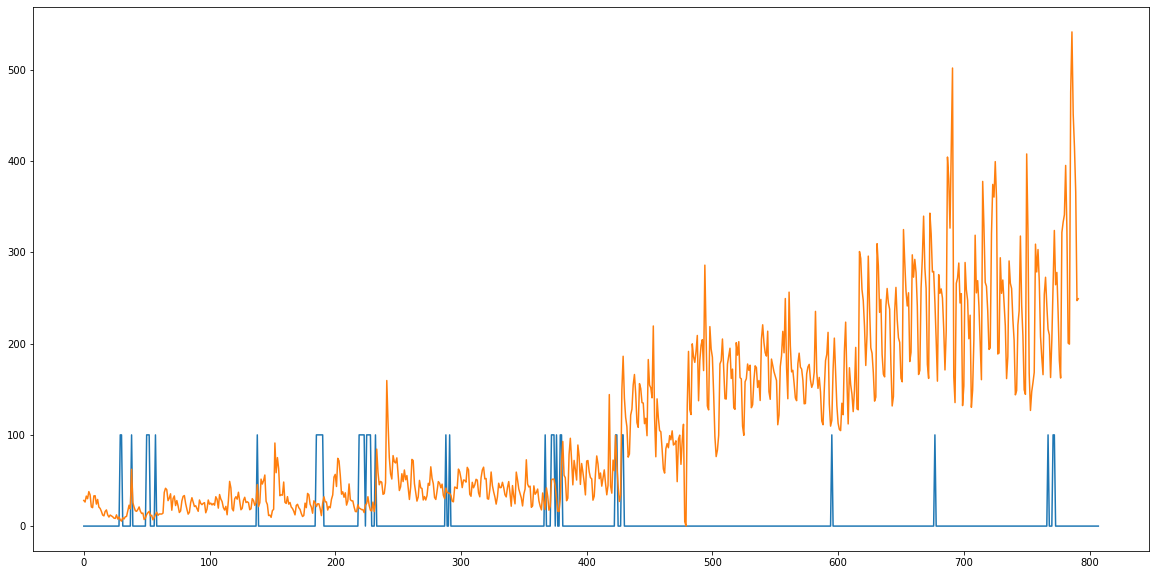

In [7]:
# 스파이크를 예측가능한것으로 보임
plt.figure(figsize=(20,10))
#login['login_id'].plot()
(login['event'].astype(int)*100).plot()
(train['사용자']/10).plot()
plt.show()

In [8]:
#제출횟수
submission =  pd.read_csv("./drive/MyDrive/데이콘/info_submission.csv", encoding = 'euc-kr', index_col=0)
submission['c_time'] = pd.to_datetime(submission['c_time']).dt.date
submission = submission.groupby('c_time').count()[['sub_id']].reset_index()

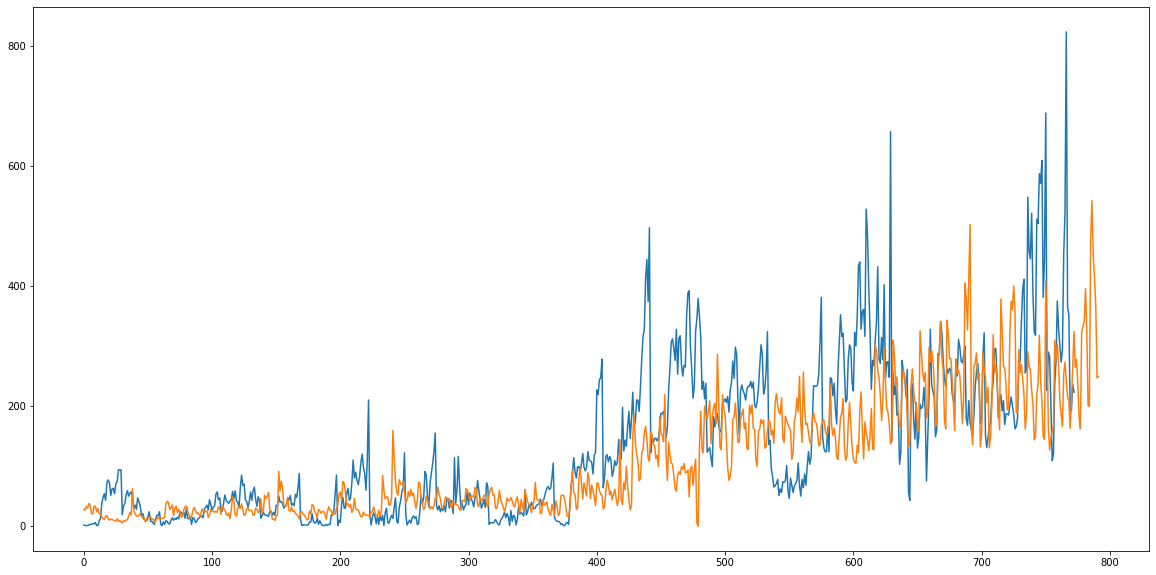

In [9]:
plt.figure(figsize=(20,10))
submission['sub_id'].plot()
(train['사용자']/10).plot()

In [10]:
# 참가자수
comp = pd.read_csv("./drive/MyDrive/데이콘/info_competition.csv", encoding = 'euc-kr', index_col=0)
comp = comp.iloc[1:]

# 일자만 남기기
comp['period_start'] = pd.to_datetime(comp['period_start']).dt.date
comp['period_end'] = pd.to_datetime(comp['period_end']).dt.date

train['participants'] = [0 for x in range(len(train))]

for start, end, val in zip(comp['period_start'], comp['period_end'],  comp['participants']): 
  
  try:
    start_idx = train[start == train['Date']].index[0]
  except:
    start_idx = min(train.index)

  try:
    end_idx = train[end == train['Date']].index[0]
  except:
    end_idx = max(train.index)
  
  for day in range(start_idx, end_idx+1):
    train['participants'][train.index == day] += val



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
# 참가자수 폭발적으로 증가하는 경우
event =train['participants'] > (train['participants'].rolling(30).mean())*1.1

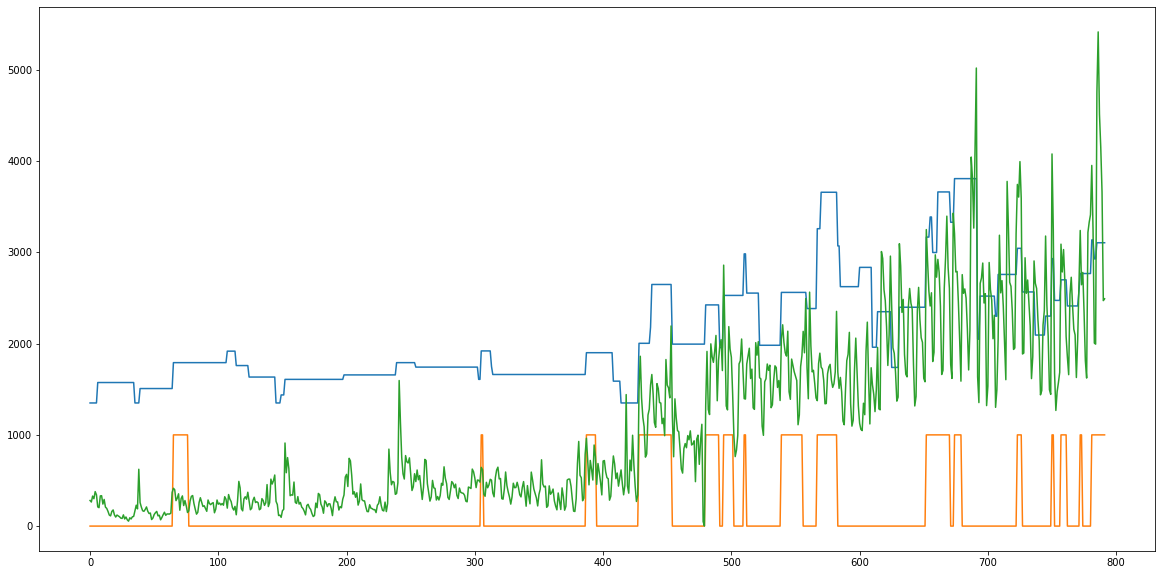

In [12]:
plt.figure(figsize=(20,10))
(train['participants']/2).plot()
(event.astype(int)*1000).plot()
(train['사용자']).plot()

- 로그인 수 증가 이벤트가 쓸만한것으로 보임 

# 전처리

In [231]:

train = pd.read_csv("./drive/MyDrive/데이콘/train.csv", encoding = 'euc-kr')

# 추가 데이터
added = pd.read_csv("./drive/MyDrive/데이콘/2차_train.csv", encoding = 'euc-kr') 
train = train.append(added)

# 시간 관련 변수들
date_time = pd.to_datetime(train.DateTime)
#일자
train['Date'] = date_time.dt.date
train = train.groupby(train['Date']).sum().reset_index()  


def log_trans(x):
  return np.log(1+x)


# 요일 혹은 분기정보
# 주기함수 형태로 변환하여 넣기
date_time = pd.to_datetime(train['Date'])

train['DayOfWeek'] = (date_time.dt.weekday)/6
train['Mon'] = (date_time.dt.month)/12
train['Quarter'] = (date_time.dt.quarter)/4

# 2018이후의 데이터만 사용
train['Year'] = (date_time.dt.year)
train = train[train['Year']>2018]
train['Year'] = train['Year'] -2019


# 보간해줌
#train.iloc[364,1:] = (train.iloc[363,1:] + train.iloc[366,1:]) // 2
#train.iloc[365,1:] = (train.iloc[365,1:] + train.iloc[366,1:]) // 2

for target in ['사용자', '세션', '신규방문자', '페이지뷰']:
    train[target] = log_trans(train[target])


train = train.dropna()


# DataLoader

In [137]:
def make_data(df, window_size=30, output_window=61):
  input_window = window_size
  # out 61 
  output_window = output_window

  # 윈도우 단위로 차분 해주기..
  # y_i = y_i - y_0
  window_x = np.zeros((df.shape[0] - (input_window + output_window), input_window, df.shape[1]-1))
  window_y = np.zeros((df.shape[0] - (input_window + output_window), output_window, 4))
  future_date = np.zeros((df.shape[0] - (input_window + output_window), output_window, 4))

  for start in range(df.shape[0] - (input_window + output_window)):
      end = start + input_window
      window_x[start,:, :] = df.iloc[start : end, 1: ].values
      window_y[start,:, :] = df.iloc[end   : end + output_window, 1: 5].values
      future_date[start,:, :] =   df.iloc[end   : end + output_window, 5: ].values

  return window_x, window_y, future_date

In [138]:
class DatasetWindows(Dataset):
  def __init__(self, df, input_days, output_days):

    x, y, future_date = make_data(df, input_days, output_days)
    
    self.x = torch.tensor(x, dtype=torch.float32).cuda()
    self.y = torch.tensor(y, dtype=torch.float32).cuda()
    self.future_date = torch.tensor(future_date, dtype=torch.float32).cuda()
  
  def __len__(self):
    return len(self.x)
    
  def __getitem__(self, idx):
    def normalize(x, y):
      init_val = torch.mean(x, dim=0)
      return x - init_val, y - init_val[:4]
    return normalize(self.x[idx,...],self.y[idx,...]), self.future_date[idx,...]

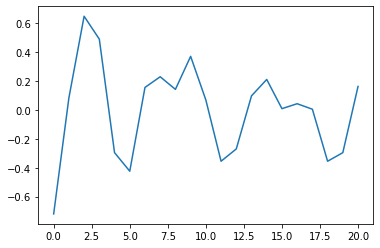

In [139]:
a = DatasetWindows(train, 21, 30)
(x, y),future_date = a.__getitem__(0)
plt.plot(x[:,0].detach().cpu())

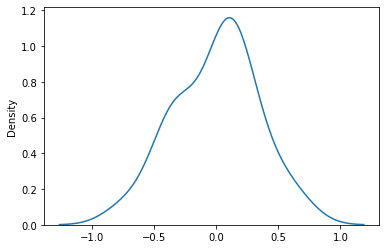

In [140]:
import seaborn as sns
sns.kdeplot(x[:,0].detach().cpu())

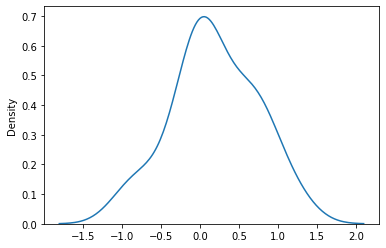

In [141]:
import seaborn as sns
sns.kdeplot(y[:,0].detach().cpu())

# 모델

In [189]:
class StackedLSTM(nn.Module):
    def __init__(self, config):
        super(StackedLSTM, self).__init__()
        self.hidden_size = config.get('hidden_size')
        self.input_days =  config.get('input_days')
        self.forecast_days  = config.get('forecast_days')
        self.dropout_p = config.get('dropout_p')

        self.embedding = nn.Sequential(nn.Linear(config.get('features'), config.get('embedded_dim')))
        
        self.LSTM_1 = nn.LSTM(input_size = config.get('input_days'),
                            hidden_size = config.get('hidden_size'),
                            num_layers=1,
                            batch_first=True)
        
        self.LSTM_2 = nn.LSTM(input_size = config.get('hidden_size'),
                            hidden_size =  config.get('hidden_size'),
                            num_layers=1,
                            batch_first=True)
        
        self.dropout = nn.Dropout(self.dropout_p)
        
        self.fc = nn.Sequential(nn.Linear( config.get('embedded_dim'), 1))
        

    def forward(self, x_time, batch_size):
        # B, 30, 1
        x_time = self.embedding(x_time)
        x_time = x_time[:,:,0].unsqueeze(-1)
        # B, 1, 30
        x_time = x_time.transpose(-2,-1)
        x_time,_ = self.LSTM_1(x_time)
        x_time = self.dropout(x_time)
        # B, 1, H
        x_time,_ = self.LSTM_2(x_time)
        # B, 1, 61
        x_time = x_time[...,-self.forecast_days:].transpose(-1,-2)
        return x_time


# 변수별로 독립 seq로 regression
class ParallelLSTM(nn.Module):
  def __init__(self, config):
    super(ParallelLSTM, self).__init__()

    self.feature_1 = StackedLSTM(config)
    self.feature_2 = StackedLSTM(config)
    self.feature_3 = StackedLSTM(config)
    self.feature_4 = StackedLSTM(config)

    self.last = nn.Linear(4,4)
  
  def forward(self, x_time, batch_size):
    
    seq_1 = self.feature_1(x_time[:,:,[0,-1,-2,-3,-4]], batch_size)
    seq_2 = self.feature_2(x_time[:,:,[1,-1,-2,-3,-4]], batch_size)
    seq_3 = self.feature_3(x_time[:,:,[2,-1,-2,-3,-4]], batch_size)
    seq_4 = self.feature_4(x_time[:,:,[3,-1,-2,-3,-4]], batch_size)
    
    #B 61 4
    out = torch.cat([seq_1, seq_2, seq_3, seq_4], dim=-1)
    out = self.last(out)

    # B 61 4
    return out

# 모델 관리

In [216]:
class ModelManager():
  def __init__(self, model_name, config, device='gpu'):
    super(ModelManager, self).__init__()
    self.input_days = config.get('input_days')
    self.batch_size = config.get('batch_size')
    self.output_days = config.get('output_days')
    self.lr = config.get('lr')
    model =  model_name(config)
    if device == 'gpu':
      model =  model.cuda()
    self.model = model

  def fit(self, num_epochs=500 ,log=False, val_set=None, train_set=None):
    
    def get_val_loss():
      val_loss = self.make_val_plot(val_set, train_set, get_loss=True)
      return val_loss

    # Train model
    model = self.model
    dataset = DatasetWindows(train_set, self.input_days, self.output_days)
    batch_size = self.batch_size
    dataloader = DataLoader(dataset, batch_size=batch_size,  num_workers=0, pin_memory=False,
                                      shuffle=False)
    optimizer = torch.optim.AdamW(model.parameters(), lr=self.lr)
    swa_scheduler = SWALR(optimizer, swa_lr=self.lr)
    swa_model = AveragedModel(model)
    self.model = swa_model

    criterion = nn.MSELoss(reduction='mean')
    running_loss = 0

    for epoch in range(num_epochs):
        for idx,data in enumerate(dataloader):
            (x, y),future_date = data
            size = x.size(0)
            train_pred = model(x, future_date)
            loss = criterion(train_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        if epoch % 10 == 9:
          swa_model.update_parameters(model)
          swa_scheduler.step()
          if log:
            val_loss = get_val_loss()
            print(f"{epoch+1} Epochs train MSE: {running_loss/(10*idx):1.5f}, ", f"{epoch+1} Epochs val MSE: {val_loss:1.5f}")
            #print(f"{epoch+1} Epochs train MSE: {running_loss/(idx):1.5f}, ", f"{epoch+1} Epochs val MSE: {val_loss:1.5f}")
            running_loss = 0


  @staticmethod
  def inverse_log(x):
    # 32bit 사용시 단위문제 발생..
    return np.exp(x)-1
  

  @staticmethod
  def denormal(init_val, y):
    return y + init_val[:4]


  def predict(self, df, repeat=0):
    input_days = self.input_days
    
    def make_time_feature(df):
      ts = pd.Series(pd.date_range(df['Date'].iloc[-1], periods = 62, freq = '1d')[1:])
      date_time = pd.to_datetime(ts)
      week = (date_time.dt.weekday)/6
      mon = (date_time.dt.month)/12
      quarter = (date_time.dt.quarter)/4
      year = (date_time.dt.year) - 2019
      return np.stack([week, mon, quarter, year], axis=-1)


    last_observe = df.iloc[-input_days:,1:]
    time_feature = make_time_feature(df)

    inp_tensor = torch.tensor(last_observe.values, dtype=torch.float32).cuda()
    time_feature = torch.tensor(time_feature, dtype=torch.float32).cuda()
    #normalizing
    init_val = inp_tensor.mean(dim=0)
    inp_tensor = inp_tensor - init_val
    inp_tensor = inp_tensor.unsqueeze(0)
    time_feature = time_feature.unsqueeze(0)

    if repeat != 0:
      prediction = [0]
      model = self.model

      for i in range(repeat):
        if i == 0:
          prediction = model(inp_tensor, time_feature)
        else:
          prediction += model(inp_tensor,  time_feature)

      prediction /= repeat
      prediction = self.inverse_log(self.denormal(init_val, prediction).cpu().detach().squeeze().numpy())
      

    else:
      # normalizing 추가
      model = self.model.eval()
      prediction = model(inp_tensor, time_feature)
      prediction = self.inverse_log(self.denormal(init_val, prediction).cpu().detach().squeeze().numpy())

    self.model = model.train()

    return  prediction.astype(np.int64)


  def make_val_plot(self, val_df, train_df, get_loss=False, repeat=0):
    #predict
    # baysian predict
    pred = self.predict(train_df, repeat)
    label = val_df

    def dacon_rmse(true, pred):  
      w0 = 1095.214646
      w1 = 1086.728535
      w2 = 268.070707
      w3 = 24236.194444

      score = (np.sqrt(np.mean(np.square(true[:,0] - pred[:,0]))) / w0 + 
               np.sqrt(np.mean(np.square(true[:,1] - pred[:,1]))) / w1 + 
               np.sqrt(np.mean(np.square(true[:,2] - pred[:,2]))) / w2 + 
               np.sqrt(np.mean(np.square(true[:,3] - pred[:,3]))) / w3  )
      return score

    if get_loss:
      return dacon_rmse(label.values, pred)

    for idx, key in enumerate(val_df.columns):
      plt.plot(figsize=(20,10))
      plt.plot(label.index,pred[:,idx])
      plt.plot(label[key])
      plt.legend(['predict', 'label'])
      plt.show()
      
    loss = dacon_rmse(label.iloc[:,:4].values, pred)
    print('RMSE : ' + str(loss))

# 모델 검증

In [247]:
# train val split
train_whole = train
train_split = train[:-31]

val = train.iloc[-31:, 1:5]
val.iloc[:,:] = (np.exp(val.values)-1).astype(np.int64)

config = {'features':5,
          'embedded_dim': 1,
          'input_days': 28,
          'output_days':31,
         'hidden_size': 32,
          'dropout_p' : 0.1,
          'forecast_days':31,
          'batch_size' : 4,
          'lr':1e-3}

simple = ModelManager(ParallelLSTM, config)
simple.fit(num_epochs=100, log=True, val_set=val, train_set=train_split)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


10 Epochs train MSE: 0.31861,  10 Epochs val MSE: 2.32622
20 Epochs train MSE: 0.29022,  20 Epochs val MSE: 2.01598
30 Epochs train MSE: 0.26983,  30 Epochs val MSE: 1.86150
40 Epochs train MSE: 0.25078,  40 Epochs val MSE: 1.76756
50 Epochs train MSE: 0.23076,  50 Epochs val MSE: 1.69729
60 Epochs train MSE: 0.21064,  60 Epochs val MSE: 1.65190
70 Epochs train MSE: 0.19068,  70 Epochs val MSE: 1.60929
80 Epochs train MSE: 0.17278,  80 Epochs val MSE: 1.58580
90 Epochs train MSE: 0.15719,  90 Epochs val MSE: 1.57351
100 Epochs train MSE: 0.14497,  100 Epochs val MSE: 1.57361


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


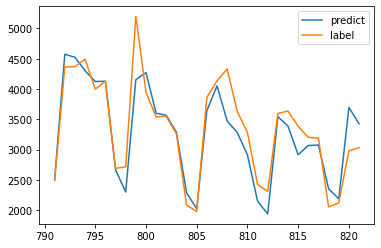

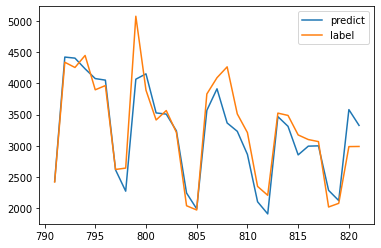

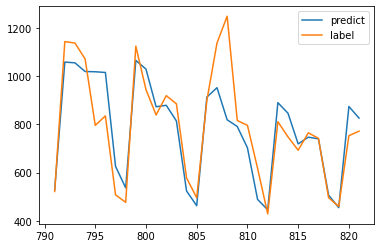

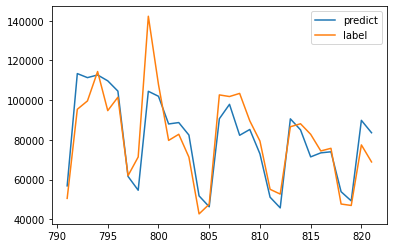

RMSE : 1.5333100118506473


In [248]:
simple.make_val_plot(val, train_split, repeat=100)

# 전체 데이터 적합

In [ ]:
simple.fit(num_epochs=50, train_set=train_whole)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


      DateTime   사용자    세션  신규방문자    페이지뷰
0   2020-11-09  4364  4340   1143   95408
1   2020-11-10  4370  4256   1137   99623
2   2020-11-11  4492  4449   1071  114438
3   2020-11-12  3998  3899    796   94730
4   2020-11-13  4130  3967    835  101484
..         ...   ...   ...    ...     ...
56  2021-01-04  1990  1948    439   45817
57  2021-01-05  2076  2028    453   48201
58  2021-01-06  3402  3333    849   87454
59  2021-01-07  3102  3040    787   76450
60  2021-01-08  2734  2686    691   67091

[61 rows x 5 columns]
saved result


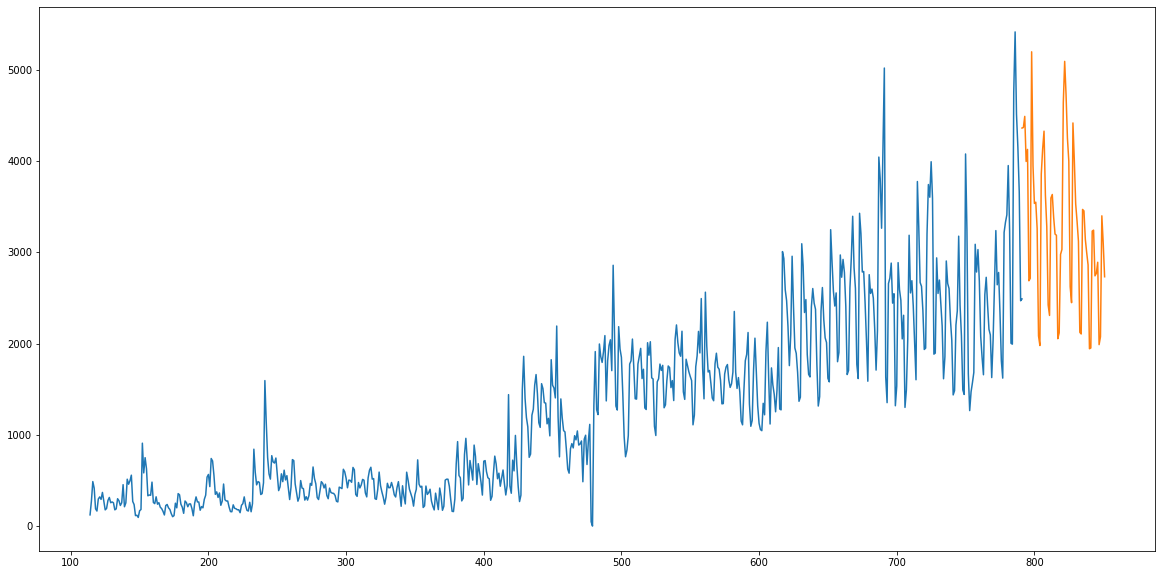

In [249]:
submission = pd.read_csv("./drive/MyDrive/데이콘/submission.csv", encoding = 'euc-kr') 

real = pd.read_csv("./drive/MyDrive/데이콘/2차_train.csv", encoding = 'euc-kr') 
date_time = pd.to_datetime(real.DateTime)
real['Date'] = date_time.dt.date
real = real.groupby(real['Date']).sum().reset_index()  

submission.iloc[:30,1:] = real.iloc[:,1:].values

submission.iloc[30:,1:] = simple.predict(train_whole.iloc[:-30,:], repeat=100)
submission.to_csv('submission.csv', index = False, encoding = 'euc-kr')
print(submission)
print('saved result')

submission.columns = ['Date',   '사용자' ,   '세션',  '신규방문자',   '페이지뷰']

def inverse_log(x):
  # 32bit 사용시 단위문제 발생..
  return (np.exp(x)-1).astype(np.int64)

original = train.iloc[:-30,:5]
original.iloc[:,1:] = inverse_log(original.iloc[:,1:].values)
submission.index = [x for x in range(max(original.index), max(original.index)+61)]

plt.figure(figsize=(20,10))
original['사용자'].plot()
submission['사용자'].plot()

# anomaly

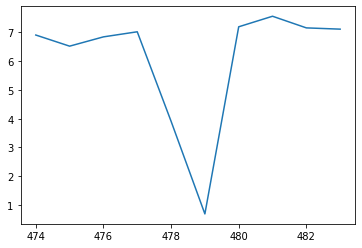

In [88]:
train.iloc[360:370,1].plot()
#train['사용자'].plot()

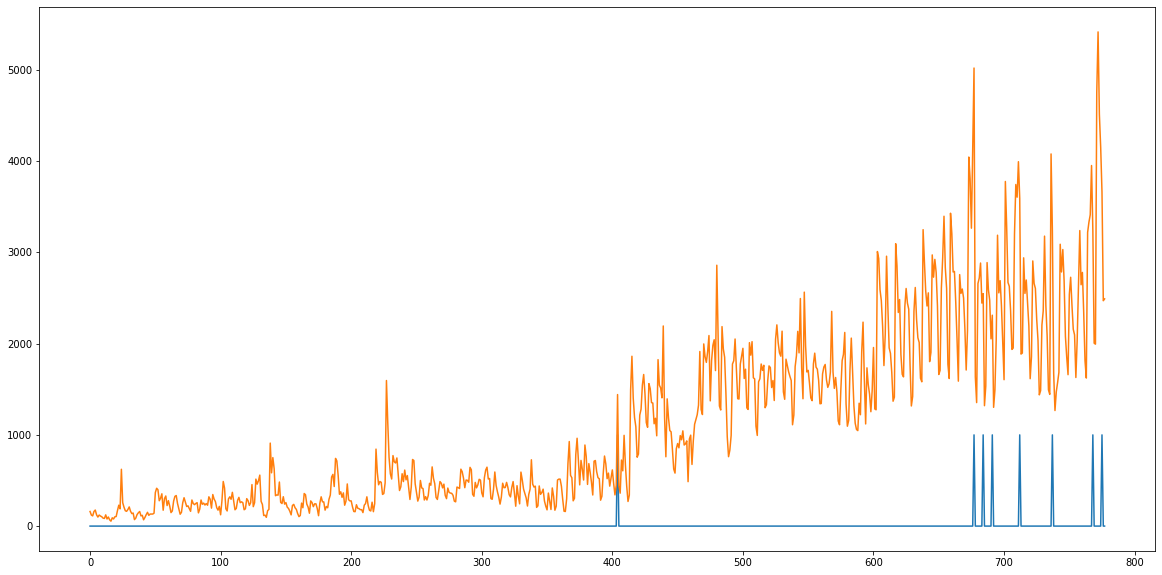

In [ ]:
plt.figure(figsize=(20,10))
event = (original['사용자'] > original['사용자'].shift(-1) + 1000).astype(int)
(event*1000).plot()
original['사용자'].plot()

In [ ]:
original[(original['페이지뷰'] > original['페이지뷰'].shift(-1) + 30000)]

,Date,사용자,세션,신규방문자,페이지뷰
677,2020-07-31,5022,5400,1690,155434
684,2020-08-07,2548,2455,592,74962
712,2020-09-04,3591,3710,928,84512
737,2020-09-29,3246,3163,760,79330
768,2020-10-30,3240,3153,715,90174
772,2020-11-03,5418,5304,1524,150888
775,2020-11-06,3662,3576,824,88014


In [ ]:
original[(original['사용자'] > original['사용자'].shift(-1) + 1000)]

,Date,사용자,세션,신규방문자,페이지뷰
404,2019-11-01,1442,1689,741,16463
677,2020-07-31,5022,5400,1690,155434
684,2020-08-07,2548,2455,592,74962
691,2020-08-14,2312,2225,529,57619
712,2020-09-04,3591,3710,928,84512
737,2020-09-29,3246,3163,760,79330
768,2020-10-30,3240,3153,715,90174
775,2020-11-06,3662,3576,824,88014


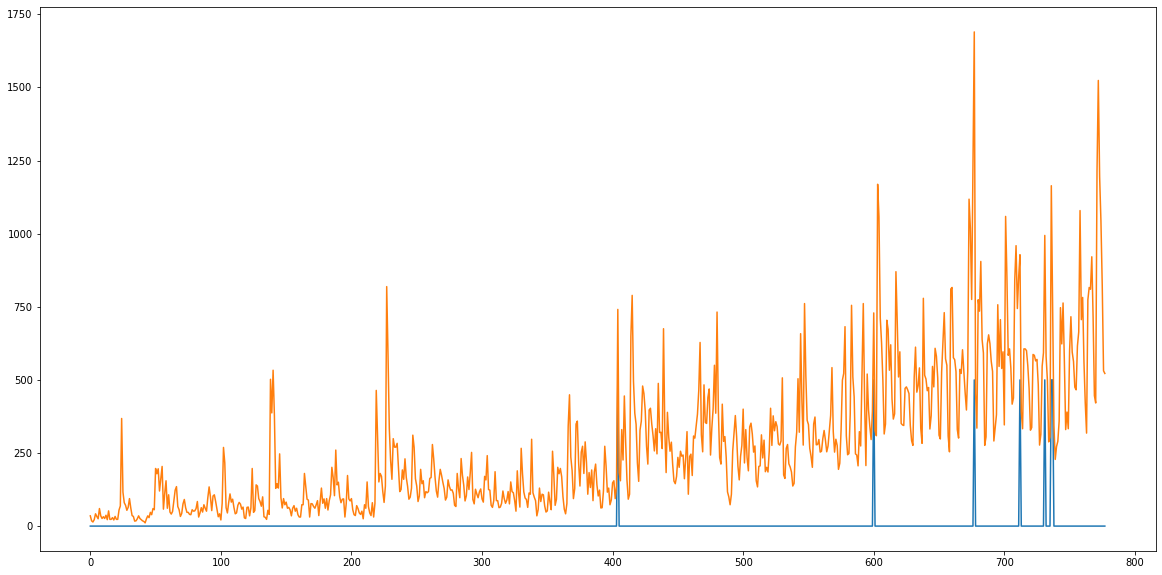

In [ ]:
plt.figure(figsize=(20,10))
event = (original['신규방문자'] > original['신규방문자'].shift(-1) + 400).astype(int)
(event*500).plot()
original['신규방문자'].plot()

In [ ]:
original[(original['신규방문자'] > original['신규방문자'].shift(-1) + 400)]

,Date,사용자,세션,신규방문자,페이지뷰
404,2019-11-01,1442,1689,741,16463
600,2020-05-15,1958,1890,729,60552
677,2020-07-31,5022,5400,1690,155434
712,2020-09-04,3591,3710,928,84512
731,2020-09-23,3179,3199,994,76103
736,2020-09-28,4080,4016,1164,97762
737,2020-09-29,3246,3163,760,79330
